c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [23:48:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 27034, number of negative: 27034
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 54068, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
XGBoost:
              precision    recall  f1-score   support

           0     0.7198    0.7154    0.7176      5407
           1     0.7171    0.7215    0.7193      5407

    accuracy                         0.7184     10814
   macro avg     0.7184    0.7184    0.7184     10814
weighted avg     0.7184    0.7184    0.7184     10814

Confusion Matrix:
 [[3868 1539]
 [1506 3901]]
Accuracy: 0.7184205659330497

LightGBM:
              precision    recall  f1-score   support

           0     0.6325    0.6553    0.6437      5407
           1     0.6424    0.61

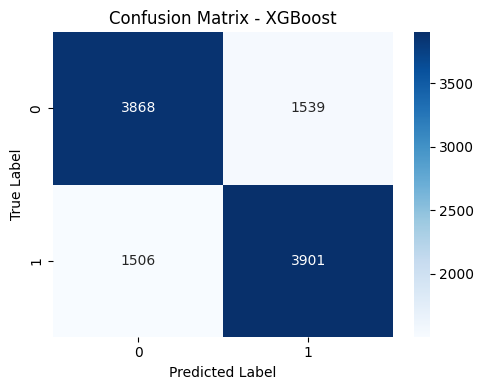

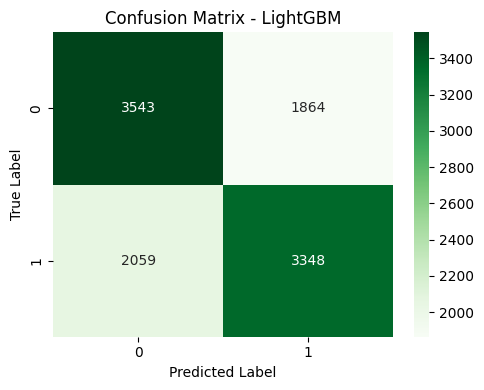

In [9]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

def get_split(X, y, test_frac=0.2, random_state=42):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_frac, random_state=random_state)
    for train_idx, test_idx in sss.split(X, y):
        return train_idx, test_idx

def save_results(report, matrix, acc, name, save_dir):
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(save_dir, f"{name}_report.csv"), index=True)
    df_cm = pd.DataFrame(matrix)
    df_cm.to_csv(os.path.join(save_dir, f"{name}_cm.csv"), index=False)
    with open(os.path.join(save_dir, f"{name}_acc.txt"), "w") as f:
        f.write(f"Accuracy: {acc:.6f}\n")

def main():
    df = pd.read_csv(r'D:\dow\project_final\data\iot_train_augmented.csv')
    features = [
        'Normalized_Temp', 'Normalized_Vibration', 'Normalized_Pressure',
        'Normalized_Voltage', 'Normalized_Current',
        'FFT_Feature1', 'FFT_Feature2', 'Anomaly_Score'
    ]
    save_dir = r'D:\dow\project_final\evaluation'
    os.makedirs(save_dir, exist_ok=True)

    X_train = df[features]
    y_train = df['Fault_Status']

    train_idx, test_idx = get_split(X_train, y_train)
    X_test = X_train.iloc[test_idx]
    y_test = y_train.iloc[test_idx]

    # XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    metrics_xgb = classification_report(y_test, y_pred_xgb, output_dict=True, digits=4)
    matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
    acc_xgb = accuracy_score(y_test, y_pred_xgb)
    save_results(metrics_xgb, matrix_xgb, acc_xgb, "xgb", save_dir)
    joblib.dump(xgb, os.path.join(save_dir, "xgb_model.pkl"))

    # LightGBM
    lgbm = LGBMClassifier(random_state=42)
    lgbm.fit(X_train, y_train)
    y_pred_lgbm = lgbm.predict(X_test)
    metrics_lgbm = classification_report(y_test, y_pred_lgbm, output_dict=True, digits=4)
    matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
    save_results(metrics_lgbm, matrix_lgbm, acc_lgbm, "lgbm", save_dir)
    joblib.dump(lgbm, os.path.join(save_dir, "lgbm_model.pkl"))

    print("XGBoost:")
    print(classification_report(y_test, y_pred_xgb, digits=4))
    print("Confusion Matrix:\n", matrix_xgb)
    print("Accuracy:", acc_xgb)
    print("\nLightGBM:")
    print(classification_report(y_test, y_pred_lgbm, digits=4))
    print("Confusion Matrix:\n", matrix_lgbm)
    print("Accuracy:", acc_lgbm)

    # --- Vẽ confusion matrix ---
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix_xgb, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - XGBoost')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix_lgbm, annot=True, fmt='d', cmap='Greens')
    plt.title('Confusion Matrix - LightGBM')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
